In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
from scipy.linalg import svd
import scipy.stats as stat
import sys


filepath=r"/Users/davidmiles-skov/Desktop/Academics/Machine Learning/02450 - Introduction to Machine Learning and Data Mining/Project Work/introML/data/processed_cleveland.data"



col_names = np.array(["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang","oldpeak", "slope","ca","thal","num"])

continuous_idx = np.array([0, 3, 4, 7, 9])
cat_idx = np.array([1, 2, 5, 6, 8, 10, 11, 12])
continuous_cols = col_names[continuous_idx]
cat_cols = col_names[cat_idx]



cleveland_data = pd.read_csv(filepath,names =col_names, delimiter=",")

# Cleaning up data

cleveland_data.thal=cleveland_data.thal.str.replace("?", "NaN")
cleveland_data.ca=cleveland_data.ca.str.replace("?", "NaN")

# Removing missing data

data = np.array(cleveland_data.values, dtype=np.float64)
missing_idx = np.isnan(data)
obs_w_missing = np.sum(missing_idx, 1) > 0
data_drop_missing_obs = data[np.logical_not(obs_w_missing), :]
X = data_drop_missing_obs[:, continuous_idx]

print(continuous_cols)
print(X)
print(X[:, 1:])

['age' 'trestbps' 'chol' 'thalach' 'oldpeak']
[[ 63.  145.  233.  150.    2.3]
 [ 67.  160.  286.  108.    1.5]
 [ 67.  120.  229.  129.    2.6]
 ...
 [ 68.  144.  193.  141.    3.4]
 [ 57.  130.  131.  115.    1.2]
 [ 57.  130.  236.  174.    0. ]]
[[145.  233.  150.    2.3]
 [160.  286.  108.    1.5]
 [120.  229.  129.    2.6]
 ...
 [144.  193.  141.    3.4]
 [130.  131.  115.    1.2]
 [130.  236.  174.    0. ]]


### Regression Part a

#### 2) 

Introduce a regularization parameter λ as discussed in chapter 14 of the lecture notes, and estimate the generalization error for different values of λ. Specifically, choose a reasonable range of values of λ (ideally one where the generalization error first drop and then increases), and for each value use K = 10 fold cross-validation (algorithm 5) to estimate the generalization error.

In [3]:
N, M = X.shape[0], X.shape[1]
X_s = (X - np.ones((N, 1))*X.mean(axis=0))/X.std(axis=0)
X_s

array([[ 0.93618065,  0.75038004, -0.27644339,  0.01749443,  1.06896529],
       [ 1.3789285 ,  1.59626645,  0.74455507, -1.81633388,  0.38177332],
       [ 1.3789285 , -0.65943064, -0.35349988, -0.89941972,  1.32666228],
       ...,
       [ 1.48961547,  0.69398761, -1.04700826, -0.37546878,  2.01385425],
       [ 0.27205887, -0.09550637, -2.24138382, -1.51069583,  0.12407633],
       [ 0.27205887, -0.09550637, -0.21865103,  1.06539633, -0.90671163]])

Attribute Names: ['trestbps' 'chol' 'thalach' 'oldpeak']
---- Optimal $\lambda$ ------

Optimal lambda: 1e1.0


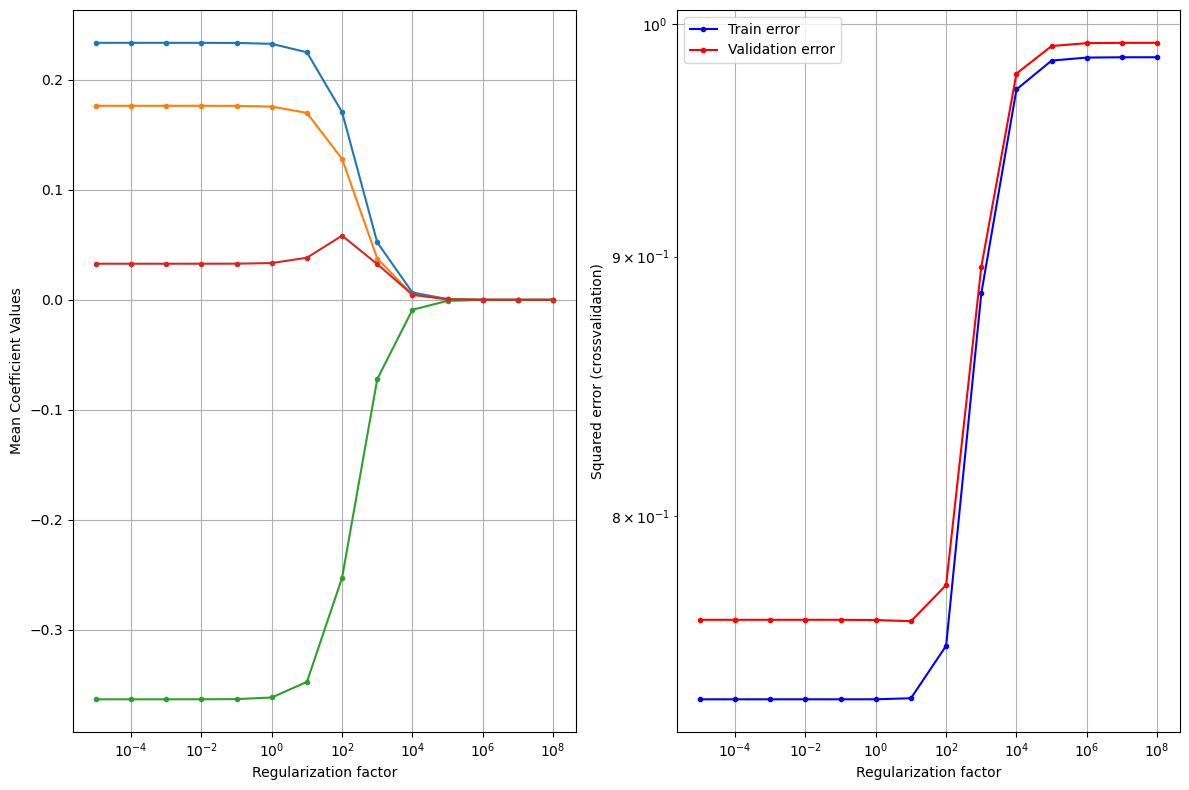

Linear regression without feature selection:
- Training error: 0.7409720929285436
- Test error:     0.764940990201356
- R^2 train:     0.2588993611215802
- R^2 test:     0.2241421221509726

Regularized linear regression:
- Training error: 0.7412886977663792
- Test error:     0.7644563066044011
- R^2 train:     0.25858270135823525
- R^2 test:     0.22463372293035117

Weights in last fold:
         Offset            0.02
       trestbps            0.23
           chol            0.17
        thalach           -0.35
        oldpeak            0.04


In [5]:




def regularisation_parameter_investigation_bigLdog(X, y):

    import importlib_resources
    import numpy as np
    import sklearn.linear_model as lm
    from matplotlib.pylab import (
        figure,
        grid,
        legend,
        loglog,
        semilogx,
        show,
        subplot,
        title,
        suptitle,
        xlabel,
        ylabel,
        tight_layout
    )
    from sklearn import model_selection

    from dtuimldmtools import rlr_validate

    # filename = importlib_resources.files("dtuimldmtools").joinpath("data/body.mat")


    # mat_data = loadmat(filename)
    # X = mat_data["X"]
    # y = mat_data["y"].squeeze()
    # attributeNames = continuous_cols[1::]
    # print(f"Attribute Names: {attributeNames}")

    N, M = X.shape

    # Add offset attribute
    X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
    attributeNames = np.array(["Offset"] + [i for i in attributeNames])
    M = M + 1

    ## Crossvalidation
    # Create crossvalidation partition for evaluation
    K = 10
    CV = model_selection.KFold(K, shuffle=True)
    # CV = model_selection.KFold(K, shuffle=False)

    # Values of lambda
    # lambdas = np.arange(-100, 100)
    # lambdas = [10^]
    lambdas = np.concatenate((np.power(10.0, range(-5,0), np.arange(2, 100), )))

    # Initialize variables
    # T = len(lambdas)
    Error_train = np.empty((K, 1))
    Error_test = np.empty((K, 1))
    Error_train_rlr = np.empty((K, 1))
    Error_test_rlr = np.empty((K, 1))
    Error_train_nofeatures = np.empty((K, 1))
    Error_test_nofeatures = np.empty((K, 1))
    w_rlr = np.empty((M, K))
    mu = np.empty((K, M - 1))
    sigma = np.empty((K, M - 1))
    w_noreg = np.empty((M, K))

    k = 0
    for train_index, test_index in CV.split(X, y):
        # extract training and test set for current CV fold
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]

        mu[k, :] = np.mean(X_train[:, 1:], 0)
        sigma[k, :] = np.std(X_train[:, 1:], 0)

        X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
        X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

        
        internal_cross_validation = 10

        (
            opt_val_err,
            opt_lambda,
            mean_w_vs_lambda,
            train_err_vs_lambda,
            test_err_vs_lambda,
        ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

        # Standardize outer fold based on training set, and save the mean and standard
        # deviations since they're part of the model (they would be needed for
        # making new predictions) - for brevity we won't always store these in the scripts
        
        # mu[k, :] = np.mean(X_train[:, 1:], 0)
        # sigma[k, :] = np.std(X_train[:, 1:], 0)

        # X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
        # X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

        Xty = X_train.T @ y_train
        XtX = X_train.T @ X_train

        # Compute mean squared error without using the input data at all
        Error_train_nofeatures[k] = (
            np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
        )
        Error_test_nofeatures[k] = (
            np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
        )

        # Estimate weights for the optimal value of lambda, on entire training set
        lambdaI = opt_lambda * np.eye(M)
        lambdaI[0, 0] = 0  # Do no regularize the bias term
        w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
        # Compute mean squared error with regularization with optimal lambda
        Error_train_rlr[k] = (
            np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
        )
        Error_test_rlr[k] = (
            np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
        )

        # Estimate weights for unregularized linear regression, on entire training set
        w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
        # Compute mean squared error without regularization
        Error_train[k] = (
            np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
        )
        Error_test[k] = (
            np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
        )
        # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
        # m = lm.LinearRegression().fit(X_train, y_train)
        # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
        # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

        # Display the results for the last cross-validation fold
        if k == K - 1:
            figure(k, figsize=(12, 8))
            subplot(1, 2, 1)
            semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
            xlabel("Regularization factor")
            ylabel("Mean Coefficient Values")
            grid()
            # You can choose to display the legend, but it's omitted for a cleaner
            # plot, since there are many attributes
            # legend(attributeNames[1:], loc='best')

            subplot(1, 2, 2)
            print(f"---- Optimal $\lambda$ ------\n")
            print("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
            
            
            loglog(
                lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
            )
            xlabel("Regularization factor")
            ylabel("Squared error (crossvalidation)")
            legend(["Train error", "Validation error"])
            tight_layout()
            # suptitle(r"Mean Coefficient Values and Error rates vs $\lambda$")
            grid()

        # To inspect the used indices, use these print statements
        # print('Cross validation fold {0}/{1}:'.format(k+1,K))
        # print('Train indices: {0}'.format(train_index))
        # print('Test indices: {0}\n'.format(test_index))

        k += 1

    show()
    # Display results
    print("Linear regression without feature selection:")
    print("- Training error: {0}".format(Error_train.mean()))
    print("- Test error:     {0}".format(Error_test.mean()))
    print(
        "- R^2 train:     {0}".format(
            (Error_train_nofeatures.sum() - Error_train.sum())
            / Error_train_nofeatures.sum()
        )
    )
    print(
        "- R^2 test:     {0}\n".format(
            (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
        )
    )
    print("Regularized linear regression:")
    print("- Training error: {0}".format(Error_train_rlr.mean()))
    print("- Test error:     {0}".format(Error_test_rlr.mean()))
    print(
        "- R^2 train:     {0}".format(
            (Error_train_nofeatures.sum() - Error_train_rlr.sum())
            / Error_train_nofeatures.sum()
        )
    )
    print(
        "- R^2 test:     {0}\n".format(
            (Error_test_nofeatures.sum() - Error_test_rlr.sum())
            / Error_test_nofeatures.sum()
        )
    )

    print("Weights in last fold:")
    for m in range(M):
        print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 2)))



regularisation_parameter_investigation_bigLdog(X_s[:, 1:], X_s[:, 0])



In [47]:
10**(1.114)

13.001695780332906

### Regression part B:

Two-fold cross validation

In [15]:
def NN_linreg(X, y, K):
    
    from sklearn import model_selection

    CV_outer = model_selection.KFold(K, shuffle=True)

    for train_index_outer, test_index_outer in CV_outer.split(X, y):
        
        X_train_outer, y_train_outer = X[train_index_outer], y[train_index_outer]
        X_test_outer, y_test_outer = X[test_index_outer], y[test_index_outer]

        CV_inner = model_selection.KFold(K, shuffle=True)

        for train_index_inner, test_index_inner in CV_outer.split( X_train_outer, y_train_outer):

            X_train_inner, y_train_inner = X_train_outer[train_index_inner], y_train_outer[train_index_inner]
            # X_test_inner, y_test_inner = X[test_index_inner], y[test_index_inner]
            print(X_train_inner[0, :])
            print()

            
NN_linreg(X_s[:, 1:], X_s[:, 0], 10)
    

    



[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 1.59626645  0.74455507 -1.81633388  0.38177332]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 0.75038004 -0.27644339  0.01749443  1.06896529]

[ 1.59626645  0.74455507 -1.81633388  0.38177332]

[ 0.75038004 -0.27644339  0.017

In [16]:
A, B = X_s.shape

In [17]:
A

297